# CKA similarity between layers of a transformer

In [1]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader
from torch.utils.data import Subset

In [42]:
class CKAGatherer: 
    """
    This class is an iterator that takes in two dataloaders and the corresponding models. at each iteration it yields 
    a tuple of return objects from the two models.
    """
    def __init__(
            self, 
            model1: nn.Module,
            model2: nn.Module,
            dataloader1: DataLoader,
            dataloader2: DataLoader = None,
            device: str = 'cpu', 
            model1_mode: bool = 'hf', 
            model2_mode: bool = 'hf',
            ):
        """
        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param dataloader1: (DataLoader) Dataloader for model 1
        :param dataloader2: (DataLoader) Dataloader for model 2. If not given, dataloader1 will be used for both models.
        :param device: Device to run the model
        """
        self.model1 = model1
        self.model2 = model2
        self.model1_mode = model1_mode
        self.model2_mode = model2_mode
        self.device = device

        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)

        self.model1.eval()
        self.model2.eval()

        self.dataloader1 = dataloader1
        self.dataloader2 = dataloader2 if dataloader2 is not None else dataloader1

        self.iterator1 = iter(self.dataloader1)
        self.iterator2 = iter(self.dataloader2)

    def __iter__(self):
        return self

    def next_hf(self, model, iterator): 
        input_dict = next(iterator)
        input_ids, attention_mask = input_dict['input_ids'], input_dict['attention_mask']
        return model.generate(input_ids=input_ids.to(self.device), attention_mask=attention_mask.to(self.device), max_new_tokens=10)
    
    def next(self, model, iterator, model_mode): 
        if model_mode == 'hf': 
            return self.next_hf(model, iterator)
        else: 
            return model(next(iterator).to(self.device))

    def __next__(self):
        res1 = self.next(self.model1, self.iterator1, self.model1_mode)
        res2 = self.next(self.model2, self.iterator2, self.model2_mode)
        return res1, res2


In [19]:
from tqdm import tqdm
from functools import partial
from warnings import warn
from typing import List, Dict
import matplotlib.pyplot as plt
from torch_cka.utils import add_colorbar


class CKA:
    def __init__(self,
                 model1: nn.Module,
                 model2: nn.Module,
                 model1_name: str = None,
                 model2_name: str = None,
                 model1_layers: List[str] = None,
                 model2_layers: List[str] = None,
                 device: str ='cpu'):
        """

        :param model1: (nn.Module) Neural Network 1
        :param model2: (nn.Module) Neural Network 2
        :param model1_name: (str) Name of model 1
        :param model2_name: (str) Name of model 2
        :param model1_layers: (List) List of layers to extract features from
        :param model2_layers: (List) List of layers to extract features from
        :param device: Device to run the model
        """

        self.model1 = model1
        self.model2 = model2

        self.device = device

        self.model1_info = {}
        self.model2_info = {}

        if model1_name is None:
            self.model1_info['Name'] = model1.__repr__().split('(')[0]
        else:
            self.model1_info['Name'] = model1_name

        if model2_name is None:
            self.model2_info['Name'] = model2.__repr__().split('(')[0]
        else:
            self.model2_info['Name'] = model2_name

        if self.model1_info['Name'] == self.model2_info['Name']:
            warn(f"Both model have identical names - {self.model2_info['Name']}. " \
                 "It may cause confusion when interpreting the results. " \
                 "Consider giving unique names to the models :)")

        self.model1_info['Layers'] = []
        self.model2_info['Layers'] = []

        self.model1_features = {}
        self.model2_features = {}

        if len(list(model1.modules())) > 150 and model1_layers is None:
            warn("Model 1 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model1_layers' parameter. Your CPU/GPU will thank you :)")

        self.model1_layers = model1_layers

        if len(list(model2.modules())) > 150 and model2_layers is None:
            warn("Model 2 seems to have a lot of layers. " \
                 "Consider giving a list of layers whose features you are concerned with " \
                 "through the 'model2_layers' parameter. Your CPU/GPU will thank you :)")

        self.model2_layers = model2_layers

        self._insert_hooks()
        self.model1 = self.model1.to(self.device)
        self.model2 = self.model2.to(self.device)

        self.model1.eval()
        self.model2.eval()

    def _log_layer(self,
                   model: str,
                   name: str,
                   layer: nn.Module,
                   inp: torch.Tensor,
                   out: torch.Tensor):

        if model == "model1":
            self.model1_features[name] = out

        elif model == "model2":
            self.model2_features[name] = out

        else:
            raise RuntimeError("Unknown model name for _log_layer.")

    def _insert_hooks(self):
        # Model 1
        for name, layer in self.model1.named_modules():
            if self.model1_layers is not None:
                if name in self.model1_layers:
                    self.model1_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model1", name))
            else:
                self.model1_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model1", name))

        # Model 2
        for name, layer in self.model2.named_modules():
            if self.model2_layers is not None:
                if name in self.model2_layers:
                    self.model2_info['Layers'] += [name]
                    layer.register_forward_hook(partial(self._log_layer, "model2", name))
            else:

                self.model2_info['Layers'] += [name]
                layer.register_forward_hook(partial(self._log_layer, "model2", name))

    def _HSIC(self, K, L):
        """
        Computes the unbiased estimate of HSIC metric.

        Reference: https://arxiv.org/pdf/2010.15327.pdf Eq (3)
        """
        N = K.shape[0]
        ones = torch.ones(N, 1).to(self.device)
        result = torch.trace(K @ L)
        result += ((ones.t() @ K @ ones @ ones.t() @ L @ ones) / ((N - 1) * (N - 2))).item()
        result -= ((ones.t() @ K @ L @ ones) * 2 / (N - 2)).item()
        return (1 / (N * (N - 3)) * result).item()

    def compare(
            self,
            dataloader1: DataLoader,
            dataloader2: DataLoader = None, 
        ) -> None:
        """
        Computes the feature similarity between the models on the
        given datasets.
        :param dataloader1: (DataLoader)
        :param dataloader2: (DataLoader) If given, model 2 will run on this
                            dataset. (default = None)
        """

        if dataloader2 is None:
            warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
            dataloader2 = dataloader1

        self.model1_info['Dataset'] = dataloader1.dataset.__repr__().split('\n')[0]
        self.model2_info['Dataset'] = dataloader2.dataset.__repr__().split('\n')[0]

        N = len(self.model1_layers) if self.model1_layers is not None else len(list(self.model1.modules()))
        M = len(self.model2_layers) if self.model2_layers is not None else len(list(self.model2.modules()))

        self.hsic_matrix = torch.zeros(N, M, 3)

        num_batches = min(len(dataloader1), len(dataloader1))

        gatherer = CKAGatherer(self.model1, self.model2, dataloader1, dataloader2, self.device)
        for _ in tqdm(gatherer, desc="| Comparing features |", total=num_batches):
            for i, (name1, feat1) in enumerate(self.model1_features.items()):
                X = feat1.flatten(1)
                K = X @ X.t()
                K.fill_diagonal_(0.0)
                self.hsic_matrix[i, :, 0] += self._HSIC(K, K) / num_batches

                for j, (name2, feat2) in enumerate(self.model2_features.items()):
                    Y = feat2.flatten(1)
                    L = Y @ Y.t()
                    L.fill_diagonal_(0.0)
                    assert K.shape == L.shape, f"Feature shape mistach! {K.shape}, {L.shape}"

                    self.hsic_matrix[i, j, 1] += self._HSIC(K, L) / num_batches
                    self.hsic_matrix[i, j, 2] += self._HSIC(L, L) / num_batches

        self.hsic_matrix = self.hsic_matrix[:, :, 1] / (self.hsic_matrix[:, :, 0].sqrt() *
                                                        self.hsic_matrix[:, :, 2].sqrt())

        assert not torch.isnan(self.hsic_matrix).any(), "HSIC computation resulted in NANs"

    def export(self) -> Dict:
        """
        Exports the CKA data along with the respective model layer names.
        :return:
        """
        return {
            "model1_name": self.model1_info['Name'],
            "model2_name": self.model2_info['Name'],
            "CKA": self.hsic_matrix,
            "model1_layers": self.model1_info['Layers'],
            "model2_layers": self.model2_info['Layers'],
            "dataset1_name": self.model1_info['Dataset'],
            "dataset2_name": self.model2_info['Dataset'],

        }

    def plot_results(self,
                     save_path: str = None,
                     title: str = None):
        fig, ax = plt.subplots()
        im = ax.imshow(self.hsic_matrix, origin='lower', cmap='magma')
        ax.set_xlabel(f"Layers {self.model2_info['Name']}", fontsize=15)
        ax.set_ylabel(f"Layers {self.model1_info['Name']}", fontsize=15)

        if title is not None:
            ax.set_title(f"{title}", fontsize=18)
        else:
            ax.set_title(f"{self.model1_info['Name']} vs {self.model2_info['Name']}", fontsize=18)

        add_colorbar(im)
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(save_path, dpi=300)

        plt.show()

In [31]:
import re  
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset

In [32]:
def clear_hooks(model):
    for module in model.modules():
        module._forward_hooks.clear()
        module._backward_hooks.clear()
        module._forward_pre_hooks.clear()

In [ ]:
# Load in the GLUE data
dataset = load_dataset('glue', 'mrpc')

def prepend_translation_task(example):
    example["sentence1"] = "Translate from English to French: " + example["sentence1"]
    return example
dataset = dataset.map(prepend_translation_task)

In [33]:
# Load in T5 small 
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [36]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['sentence1'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Reusing dataset glue (/home/kacperwyrwal/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 575/575 [00:00<00:00, 883.23ba/s]


In [37]:
def match_module_names_from_pattern(model: nn.Module, pattern: str) -> list[str]:
    if isinstance(pattern, str): 
        pattern = re.compile(pattern)
    return [name for name, _ in model.named_modules() if pattern.match(name)]


def match_module_names(model: nn.Module, *patterns: str) -> list[str]: 
    if len(patterns) == 1: 
        pattern = patterns[0]
    elif len(patterns) > 1:
        pattern = re.compile('|'.join(patterns))
    return match_module_names_from_pattern(model, pattern)

In [54]:
def get_pattern(encoder_self_attention=True, 
                encoder_fc=True, 
                decoder_self_attention=True, 
                decoder_cross_attention=True, 
                decoder_fc=True):
    patterns = []

    # Patterns for encoder
    if encoder_self_attention:
        patterns.append(r'encoder\.block\.\d+\.layer\.\d+\.SelfAttention\.(q|k|v|o)')
    if encoder_fc:
        patterns.append(r'encoder\.block\.\d+\.layer\.\d+\.DenseReluDense\.(wi|wo)')

    # Patterns for decoder
    if decoder_self_attention:
        patterns.append(r'decoder\.block\.[1-9]\d*\.layer\.\d+\.SelfAttention\.(q|k|v|o)')
    if decoder_cross_attention:
        patterns.append(r'decoder\.block\.[1-9]\d*\.layer\.\d+\.EncDecAttention\.(q|k|v|o)')
    if decoder_fc:
        patterns.append(r'decoder\.block\.\d+\.layer\.\d+\.DenseReluDense\.(wi|wo)')

    return '|'.join(patterns)


def get_module_names(
    module,
    encoder_self_attention=True, 
    encoder_fc=True, 
    decoder_self_attention=True, 
    decoder_cross_attention=True, 
    decoder_fc=True, 
):
    return match_module_names_from_pattern(
        module, 
        get_pattern(encoder_self_attention, encoder_fc, decoder_self_attention, decoder_cross_attention, decoder_fc))


In [55]:
batch_size = 8
num_batches = 2
subset = Subset(dataset['test'], range(batch_size * num_batches))
drop_last = True 
dataloader1 = DataLoader(subset,batch_size=batch_size, drop_last=drop_last)
dataloader2 = DataLoader(subset,batch_size=batch_size, drop_last=drop_last)

/tmp/ipykernel_43262/792088816.py:48: UserWarning: Both model have identical names - T5ForConditionalGeneration. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 2/2 [00:17<00:00,  8.68s/it]


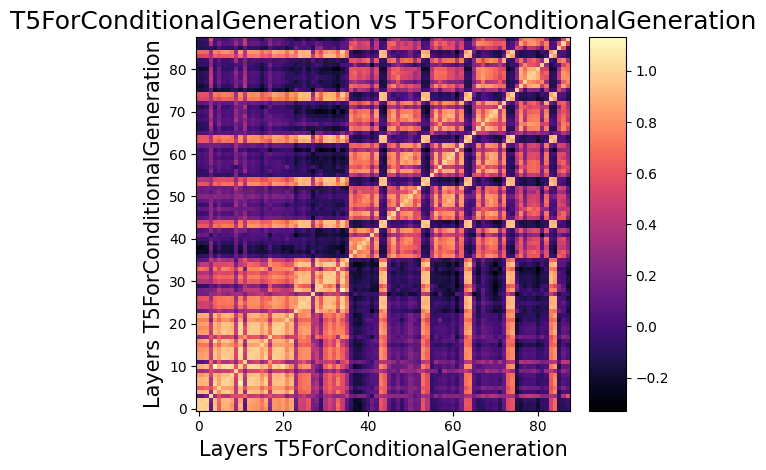

In [56]:
clear_hooks(model)
model_layers = get_module_names(model)
cka = CKA(model, model, model1_layers=model_layers, model2_layers=model_layers)
cka.compare(dataloader1, dataloader2)
cka.plot_results()